In [1]:
DF_PATH       = "../data/processed/2_cleaned_data.pkl"

ROLE_COLS     = ['DevType']
TECH_COLS     = ['LanguageWorkedWith' , 'DatabaseWorkedWith' , 'WebframeWorkedWith', 'MiscTechWorkedWith']

EXPORT_PATH    = "../data/processed/production_dummy_app.pkl"

In [2]:
## Major Libraries
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

## Other
import os, joblib, missingno
import logging
import pickle

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

## sklearn -- Preprocessing & Tuning & Transformation
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures , MultiLabelBinarizer , RobustScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion , make_pipeline
from sklearn_features.transformers import DataFrameSelector
from sklearn import tree

## sklearn -- metrics
from sklearn.metrics import mean_squared_error, r2_score , auc, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn import metrics

## sklearn -- Models
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.cluster import KMeans , AgglomerativeClustering

----------------------------------------------------------------------------------------------------------------------------------------------------

Read Data

In [3]:
# Read Data 
df = pd.read_pickle(DF_PATH)
df = df.drop("skills_clusters",axis=1).copy() 

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


---------------------------------------------------------------------------------------------------------------------------------------------------

Functions

In [4]:
def generate_role_data(role_name):
    ''' Generate Balaned Data for modelling a single job '''
    role_mask = (df['DevType'][role_name] == 1)
    
    role_index = df[role_mask].index.to_series()
    other_index = df[~role_mask].index.to_series()
    
    resample_size = int(len(role_index))
    if(len(other_index) > resample_size):
        other_index = other_index.sample(resample_size)
       
    role_df = df.loc[role_index.tolist() + other_index.tolist()].copy()
    bin_role = role_df['DevType'][role_name]
    skills = role_df.drop('DevType',axis=1).droplevel(0,axis=1).copy()
    
    return skills , bin_role

In [5]:
generate_role_data('Data or business analyst')[1].value_counts()

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


0    1059
1    1059
Name: Data or business analyst, dtype: int64

--------------------------------------------------------------------------------------------------------------------------------------------

Create Model

Decision Tree

Vanilla Model

In [6]:
roles = df['DevType'].columns.tolist()

In [7]:
roles

['Academic researcher',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'DevOps specialist',
 'Developer, QA or test',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, game or graphics',
 'Developer, mobile',
 'Engineer, data',
 'Scientist',
 'System administrator']

In [8]:
models = {}

for role in roles:
    skills , bin_role = generate_role_data(role)
    X_train, X_test, Y_train, Y_test = train_test_split(skills, bin_role, test_size=0.2, random_state=0)

    role_clf = tree.DecisionTreeClassifier()
    role_clf.fit(X_train,Y_train)
    
    score_train = precision_score(Y_train , role_clf.predict(X_train))
    score_test = precision_score(Y_test , role_clf.predict(X_test))
    
    models[role] = {'clf': role_clf,
                    'scores': [score_train,score_test]}

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users

In [9]:
pd.DataFrame(models).T

,clf,scores
Academic researcher,DecisionTreeClassifier(),"[0.9951219512195122, 0.68]"
Data or business analyst,DecisionTreeClassifier(),"[0.9976162097735399, 0.7136150234741784]"
Data scientist or machine learning specialist,DecisionTreeClassifier(),"[0.9980237154150198, 0.7888888888888889]"
Database administrator,DecisionTreeClassifier(),"[0.9965457685664939, 0.6370370370370371]"
DevOps specialist,DecisionTreeClassifier(),"[0.9989572471324296, 0.6638297872340425]"
"Developer, QA or test",DecisionTreeClassifier(),"[0.9983844911147012, 0.5759493670886076]"
"Developer, back-end",DecisionTreeClassifier(),"[0.9811135982092893, 0.6147450110864745]"
"Developer, desktop or enterprise applications",DecisionTreeClassifier(),"[0.9931856899488927, 0.6211072664359861]"
"Developer, embedded applications or devices",DecisionTreeClassifier(),"[0.9978655282817502, 0.7489711934156379]"
"Developer, front-end",DecisionTreeClassifier(),"[0.9904435187454056, 0.6743961352657005]"


HyperParameter Tuning Model

Illustration

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


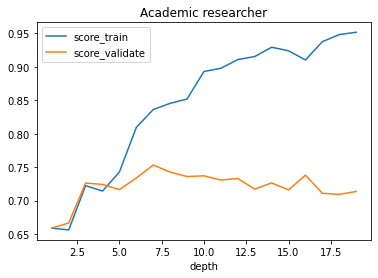

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


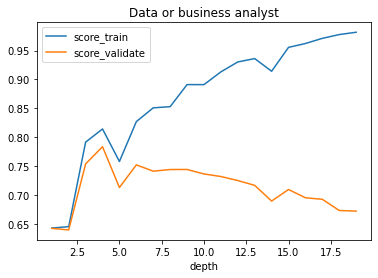

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


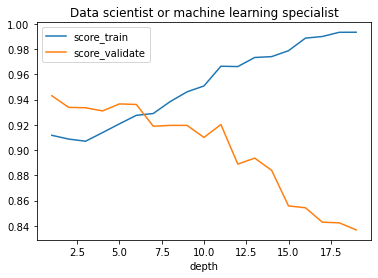

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


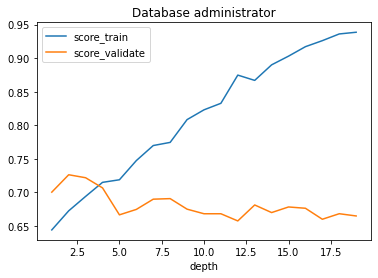

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


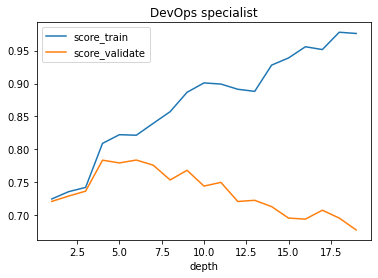

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


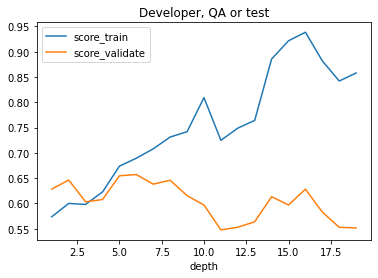

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


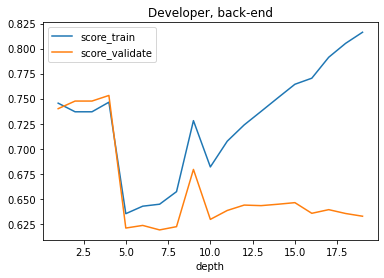

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


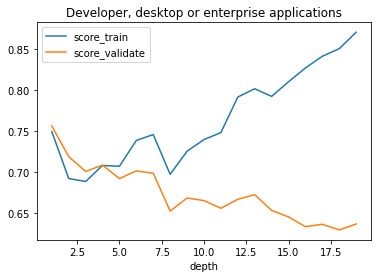

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


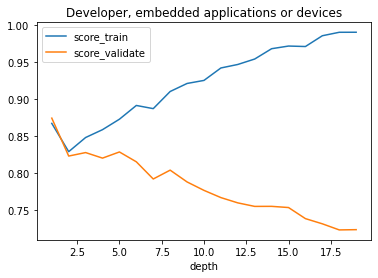

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


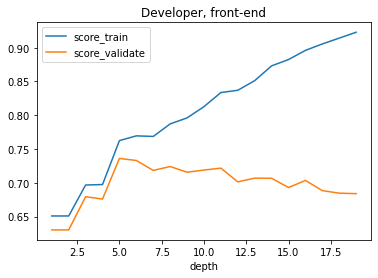

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


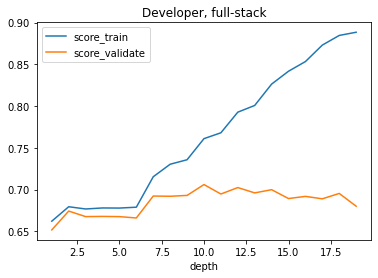

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


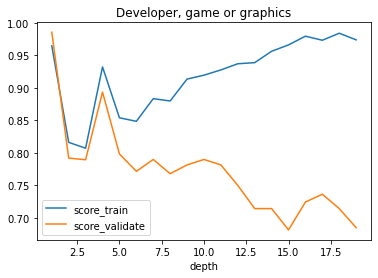

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


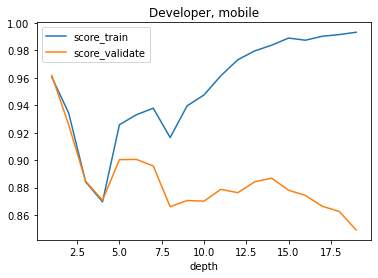

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


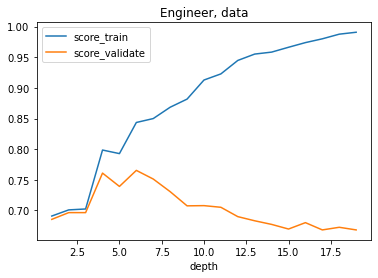

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


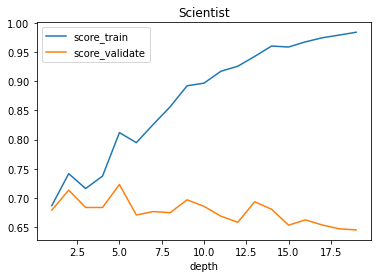

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


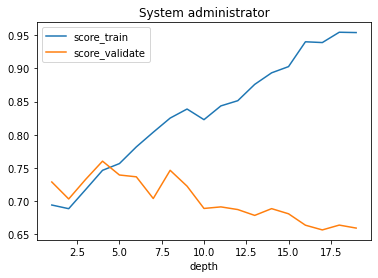

In [10]:
for role in roles :
    
    skills , bin_role = generate_role_data(role)
    X_train, X_test, Y_train, Y_test = train_test_split(skills, bin_role, random_state=0)
    X_train, X_validate, Y_train, Y_validate = train_test_split(skills, bin_role, random_state=0)
    
    hpt = []
    
    for depth in list(range(1,20)):
        
        role_clf = tree.DecisionTreeClassifier(max_depth=depth)
        role_clf.fit(X_train , Y_train)
        
        score_train = precision_score(Y_train , role_clf.predict(X_train))
        score_validate = precision_score(Y_validate , role_clf.predict(X_validate))
        
        hpt.append([depth , score_train , score_validate])
     
    hpt = pd.DataFrame(hpt , columns = ['depth','score_train','score_validate']).set_index('depth')
    hpt.plot(title=role)
    plt.show()

Manual Implementation

In [11]:
models ={}

for role in roles :
    
    skills , bin_role = generate_role_data(role)
    X_train, X_test, Y_train, Y_test = train_test_split(skills, bin_role, random_state=0)
    X_train, X_validate, Y_train, Y_validate = train_test_split(skills, bin_role, random_state=0)
    
    best_model = None
    best_validation = -np.Inf
    
    for depth in list(range(1,10)):
        
        role_clf = tree.DecisionTreeClassifier(max_depth=depth)
        role_clf.fit(X_train , Y_train)
        
        score_train = f1_score(Y_train , role_clf.predict(X_train))
        score_validate = f1_score(Y_validate , role_clf.predict(X_validate))
        
        if score_validate > best_validation :
            best_model = role_clf
            best_validation = score_validate
    
    # Recalculate Scores
    score_train = f1_score(Y_train , best_model.predict(X_train))
    score_validate = f1_score(Y_validate , best_model.predict(X_validate))
    score_test = f1_score(Y_test , best_model.predict(X_test))
    
    models[role] = {'model': best_model,
                    'data': {'X':skills,
                             'Y':bin_role},
                    'scores': {'score_train':score_train,
                               'score_validate':score_validate,
                               'score_test':score_test}}
    
    # Display
    print("************************************")
    print(role)
    print(tree.export_text(best_model , feature_names=X_train.columns.tolist()))
    print("************************************")

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Academic researcher
|--- Python <= 0.50
|   |--- R <= 0.50
|   |   |--- C <= 0.50
|   |   |   |--- C++ <= 0.50
|   |   |   |   |--- Assembly <= 0.50
|   |   |   |   |   |--- Haskell <= 0.50
|   |   |   |   |   |   |--- Julia <= 0.50
|   |   |   |   |   |   |   |--- Flutter <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- Flutter >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Julia >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Haskell >  0.50
|   |   |   |   |   |   |--- Scala <= 0.50
|   |   |   |   |   |   |   |--- MySQL <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- MySQL >  0.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Scala >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- Assembly >  0.50
|   |   |   |   |   |--- MariaDB <= 0.50
|   |   |   |   |   |

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Data scientist or machine learning specialist
|--- Pandas <= 0.50
|   |--- R <= 0.50
|   |   |--- TensorFlow <= 0.50
|   |   |   |--- class: 0
|   |   |--- TensorFlow >  0.50
|   |   |   |--- class: 1
|   |--- R >  0.50
|   |   |--- Spring <= 0.50
|   |   |   |--- class: 1
|   |   |--- Spring >  0.50
|   |   |   |--- class: 0
|--- Pandas >  0.50
|   |--- Express <= 0.50
|   |   |--- PHP <= 0.50
|   |   |   |--- class: 1
|   |   |--- PHP >  0.50
|   |   |   |--- class: 1
|   |--- Express >  0.50
|   |   |--- Firebase <= 0.50
|   |   |   |--- class: 0
|   |   |--- Firebase >  0.50
|   |   |   |--- class: 1

************************************
************************************
Database administrator
|--- SQL <= 0.50
|   |--- React.js <= 0.50
|   |   |--- MySQL <= 0.50
|   |   |   |--- C++ <= 0.50
|   |   |   |   |--- Angular <= 0.50
|   |   |   |   |   |--- Bash/Shell/PowerShell <= 0.50
|   |   |   |   |   |   |--- Assembly <= 0.50
|   |   |   |   

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
DevOps specialist
|--- Bash/Shell/PowerShell <= 0.50
|   |--- Teraform <= 0.50
|   |   |--- Ansible <= 0.50
|   |   |   |--- Go <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Go >  0.50
|   |   |   |   |--- class: 1
|   |   |--- Ansible >  0.50
|   |   |   |--- PostgreSQL <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- PostgreSQL >  0.50
|   |   |   |   |--- class: 1
|   |--- Teraform >  0.50
|   |   |--- Ansible <= 0.50
|   |   |   |--- Java <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Java >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Ansible >  0.50
|   |   |   |--- class: 1
|--- Bash/Shell/PowerShell >  0.50
|   |--- Ansible <= 0.50
|   |   |--- Teraform <= 0.50
|   |   |   |--- R <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- R >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Teraform >  0.50
|   |   |   |--- Firebase <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- Firebase >  0.50
|   |   |   |   

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Developer, back-end
|--- Redis <= 0.50
|   |--- Spring <= 0.50
|   |   |--- SQL <= 0.50
|   |   |   |--- Go <= 0.50
|   |   |   |   |--- Firebase <= 0.50
|   |   |   |   |   |--- PostgreSQL <= 0.50
|   |   |   |   |   |   |--- .NET Core <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- .NET Core >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- PostgreSQL >  0.50
|   |   |   |   |   |   |--- React.js <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- React.js >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- Firebase >  0.50
|   |   |   |   |   |--- PHP <= 0.50
|   |   |   |   |   |   |--- Scala <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Scala >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- PHP >  0.50
|   |   |   |   |   |   |--- Node.js <= 0.50
|   |   |   |   |   |   |   |--- class: 

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Developer, desktop or enterprise applications
|--- .NET <= 0.50
|   |--- C++ <= 0.50
|   |   |--- Java <= 0.50
|   |   |   |--- C# <= 0.50
|   |   |   |   |--- C <= 0.50
|   |   |   |   |   |--- VBA <= 0.50
|   |   |   |   |   |   |--- R <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- R >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- VBA >  0.50
|   |   |   |   |   |   |--- Symfony <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Symfony >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- C >  0.50
|   |   |   |   |   |--- Objective-C <= 0.50
|   |   |   |   |   |   |--- Microsoft SQL Server <= 0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- Microsoft SQL Server >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- Objective-C >  0.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- C# >  0

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Developer, front-end
|--- JavaScript <= 0.50
|   |--- HTML/CSS <= 0.50
|   |   |--- Python <= 0.50
|   |   |   |--- Firebase <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Firebase >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Python >  0.50
|   |   |   |--- Bash/Shell/PowerShell <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Bash/Shell/PowerShell >  0.50
|   |   |   |   |--- class: 0
|   |--- HTML/CSS >  0.50
|   |   |--- TypeScript <= 0.50
|   |   |   |--- Bash/Shell/PowerShell <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Bash/Shell/PowerShell >  0.50
|   |   |   |   |--- class: 0
|   |   |--- TypeScript >  0.50
|   |   |   |--- C <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- C >  0.50
|   |   |   |   |--- class: 0
|--- JavaScript >  0.50
|   |--- React.js <= 0.50
|   |   |--- HTML/CSS <= 0.50
|   |   |   |--- Angular <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- Angular >  0.50
|   |   |   |   |---

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Developer, full-stack
|--- JavaScript <= 0.50
|   |--- TypeScript <= 0.50
|   |   |--- jQuery <= 0.50
|   |   |   |--- Angular <= 0.50
|   |   |   |   |--- C# <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- C# >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Angular >  0.50
|   |   |   |   |--- C++ <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- C++ >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- jQuery >  0.50
|   |   |   |--- C <= 0.50
|   |   |   |   |--- React.js <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- React.js >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- C >  0.50
|   |   |   |   |--- Cordova <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Cordova >  0.50
|   |   |   |   |   |--- class: 1
|   |--- TypeScript >  0.50
|   |   |--- HTML/CSS <= 0.50
|   |   |   |--- React.js <= 0.50
|   |   |   |   |--- Angular <= 0.50
|   |   |   |   |   |--- class: 

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Developer, mobile
|--- Swift <= 0.50
|   |--- Kotlin <= 0.50
|   |   |--- Firebase <= 0.50
|   |   |   |--- React Native <= 0.50
|   |   |   |   |--- Xamarin <= 0.50
|   |   |   |   |   |--- Flutter <= 0.50
|   |   |   |   |   |   |--- Cordova <= 0.50
|   |   |   |   |   |   |   |--- Java <= 0.50
|   |   |   |   |   |   |   |   |--- Objective-C <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- Objective-C >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Java >  0.50
|   |   |   |   |   |   |   |   |--- SQLite <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- SQLite >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Cordova >  0.50
|   |   |   |   |   |   |   |--- Laravel <= 0.50
|   |   |   |   |   |   |   |   |--- PostgreSQL <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1
|

C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
Engineer, data
|--- Python <= 0.50
|   |--- Apache Spark <= 0.50
|   |   |--- class: 0
|   |--- Apache Spark >  0.50
|   |   |--- class: 1
|--- Python >  0.50
|   |--- Pandas <= 0.50
|   |   |--- class: 1
|   |--- Pandas >  0.50
|   |   |--- class: 1

************************************
************************************
Scientist
|--- Python <= 0.50
|   |--- R <= 0.50
|   |   |--- C <= 0.50
|   |   |   |--- class: 0
|   |   |--- C >  0.50
|   |   |   |--- class: 1
|   |--- R >  0.50
|   |   |--- Scala <= 0.50
|   |   |   |--- class: 1
|   |   |--- Scala >  0.50
|   |   |   |--- class: 0
|--- Python >  0.50
|   |--- Node.js <= 0.50
|   |   |--- SQL <= 0.50
|   |   |   |--- class: 1
|   |   |--- SQL >  0.50
|   |   |   |--- class: 1
|   |--- Node.js >  0.50
|   |   |--- Pandas <= 0.50
|   |   |   |--- class: 0
|   |   |--- Pandas >  0.50
|   |   |   |--- class: 1

************************************


C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
C:\Users\Access\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


************************************
System administrator
|--- Bash/Shell/PowerShell <= 0.50
|   |--- MariaDB <= 0.50
|   |   |--- VBA <= 0.50
|   |   |   |--- class: 0
|   |   |--- VBA >  0.50
|   |   |   |--- class: 1
|   |--- MariaDB >  0.50
|   |   |--- SQLite <= 0.50
|   |   |   |--- class: 1
|   |   |--- SQLite >  0.50
|   |   |   |--- class: 1
|--- Bash/Shell/PowerShell >  0.50
|   |--- React.js <= 0.50
|   |   |--- Spring <= 0.50
|   |   |   |--- class: 1
|   |   |--- Spring >  0.50
|   |   |   |--- class: 0
|   |--- React.js >  0.50
|   |   |--- Rust <= 0.50
|   |   |   |--- class: 0
|   |   |--- Rust >  0.50
|   |   |   |--- class: 1

************************************


Export

In [12]:
os.makedirs(os.path.dirname(EXPORT_PATH), exist_ok =True)
with open(EXPORT_PATH, 'wb') as handle:
    pickle.dump(models,handle)